# Create Dataset (Capture the Images)

In [2]:
import os
import cv2


DATA_DIR = './data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

number_of_classes = 10
dataset_size = 200

top, right, bottom, left = 10, 350, 225, 590

cap = cv2.VideoCapture(0)
for j in range(number_of_classes):
    if not os.path.exists(os.path.join(DATA_DIR, str(j))):
        os.makedirs(os.path.join(DATA_DIR, str(j)))

    print('Collecting data for class {}'.format(j))

    done = False
    while True:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)

        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
        roi = frame[top:bottom, right:left]
        cv2.putText(frame, 'Ready? Press "Q" ! :)', (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3,
                    cv2.LINE_AA)

        cv2.imshow('frame', frame)
        if cv2.waitKey(25) == ord('q'):
            break

    counter = 0
    while counter < dataset_size:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
        roi = frame[top:bottom, right:left]

        cv2.imshow('frame', frame)
        cv2.waitKey(25)
        cv2.imwrite(os.path.join(DATA_DIR, str(j), '{}.jpg'.format(counter)), roi)

        counter += 1

cap.release()
cv2.destroyAllWindows()


# Pre-Process Images

In [3]:
import os
import pickle

import mediapipe as mp
import cv2
import matplotlib.pyplot as plt


mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

DATA_DIR = './data'

data = []
labels = []
for dir_ in os.listdir(DATA_DIR):
    for img_path in os.listdir(os.path.join(DATA_DIR, dir_)):
        data_aux = []

        x_ = []
        y_ = []

        img = cv2.imread(os.path.join(DATA_DIR, dir_, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rgb)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y

                    x_.append(x)
                    y_.append(y)

                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append(x - min(x_))
                    data_aux.append(y - min(y_))

            data.append(data_aux)
            labels.append(dir_)

f = open('data.pickle', 'wb')
pickle.dump({'data': data, 'labels': labels}, f)
f.close()


# Train Dataset

In [15]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

data_dict = pickle.load(open('./data.pickle', 'rb'))

data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels'])

# Reshape data to fit the CNN input (assuming 21 landmarks x 2 (x, y) = 42 features)
data = data.reshape((-1, 6, 7, 1)) #6*7 = 42

# Normalize data
data = data / 255.0

#Convert string labels into integers (e.g. '0' -> 0)
labels = np.array(labels, dtype=int)

# Split data into train and test sets with fixed random state
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,  random_state=42)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(6, 7, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(labels)), activation='softmax')
])

# Compile the model
history = model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(x_train, y_train, epochs=500, batch_size=64, validation_split=0.1)

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print('Test accuracy: {:.2f}%'.format(score[1] * 100))

# Save the model
model.save('cnn.h5')



Epoch 1/500
68/68 [==============================] - 4s 6ms/step - loss: 2.3028 - accuracy: 0.0975 - val_loss: 2.3030 - val_accuracy: 0.0833
Epoch 2/500
68/68 [==============================] - 0s 4ms/step - loss: 2.3026 - accuracy: 0.1056 - val_loss: 2.3032 - val_accuracy: 0.0833
Epoch 3/500
68/68 [==============================] - 0s 3ms/step - loss: 2.3025 - accuracy: 0.1056 - val_loss: 2.3033 - val_accuracy: 0.0833
Epoch 4/500
68/68 [==============================] - 0s 3ms/step - loss: 2.3023 - accuracy: 0.1056 - val_loss: 2.3031 - val_accuracy: 0.0833
Epoch 5/500
68/68 [==============================] - 0s 3ms/step - loss: 2.3020 - accuracy: 0.1056 - val_loss: 2.3027 - val_accuracy: 0.0833
Epoch 6/500
68/68 [==============================] - 0s 3ms/step - loss: 2.3013 - accuracy: 0.1084 - val_loss: 2.3023 - val_accuracy: 0.0833
Epoch 7/500
68/68 [==============================] - 0s 3ms/step - loss: 2.3003 - accuracy: 0.1114 - val_loss: 2.3004 - val_accuracy: 0.0833
Epoch 8/500
6

38/38 [==============================] - 0s 1ms/step
Test loss: 0.00042555679101496935
Test accuracy: 100.00%


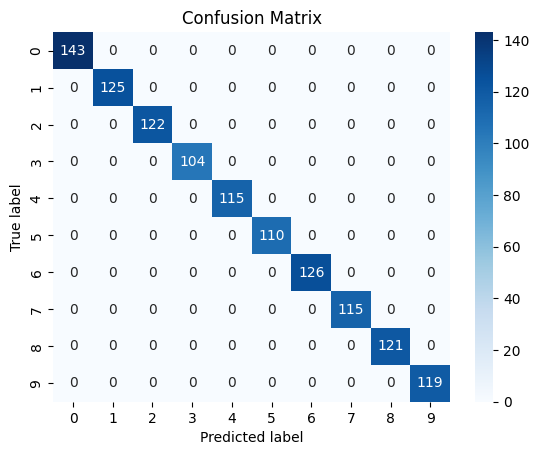

Testing Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00       125
           2       1.00      1.00      1.00       122
           3       1.00      1.00      1.00       104
           4       1.00      1.00      1.00       115
           5       1.00      1.00      1.00       110
           6       1.00      1.00      1.00       126
           7       1.00      1.00      1.00       115
           8       1.00      1.00      1.00       121
           9       1.00      1.00      1.00       119

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

Precision: 100.00%
Recall: 100.00%
F1 score: 100.00%


Plotting training loss and val loss versus epoch


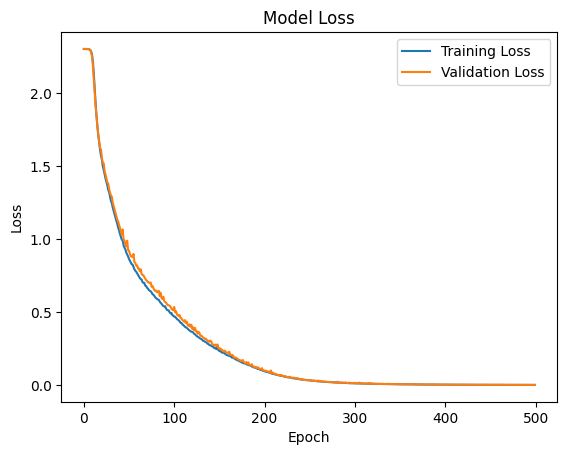

Plotting training accuracy and val accuracy versus epoch


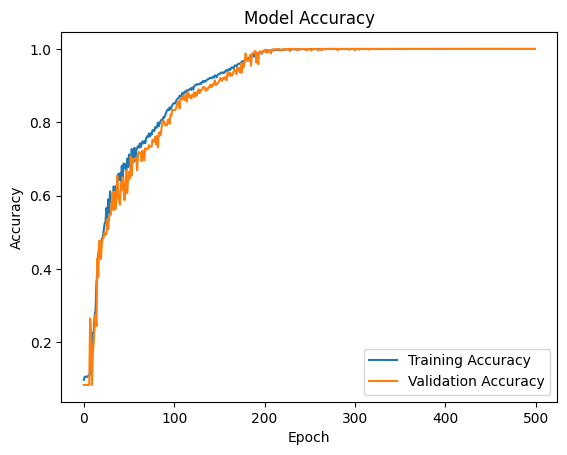

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix


model = load_model('./cnn.h5')

# Model prediction
y_pred = model.predict(x_test)
y_pred_int = y_pred.argmax(axis=-1)



#TESTING#TESTING#TESTING#TESTING#TESTING#TESTING#TESTING#TESTING#TESTING#TESTING#TESTING#TESTING#TESTING#TESTING

#Model test & accuracy loss
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print('Test accuracy: {:.2f}%'.format(score[1] * 100))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_int)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


#Classification report
report = classification_report(y_test, y_pred_int)
print("Testing Classification report:")
print(report)


#Summaries of classification report
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, y_pred_int, average='macro')
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1score * 100))

print("\n")

#TRAINING#TRAINING#TRAINING#TRAINING#TRAINING#TRAINING#TRAINING#TRAINING#TRAINING#TRAINING#TRAINING#TRAINING

# Plot training and validation loss over time
print("Plotting training loss and val loss versus epoch")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation accuracy over time
print("Plotting training accuracy and val accuracy versus epoch")
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# Visualise the Dataset

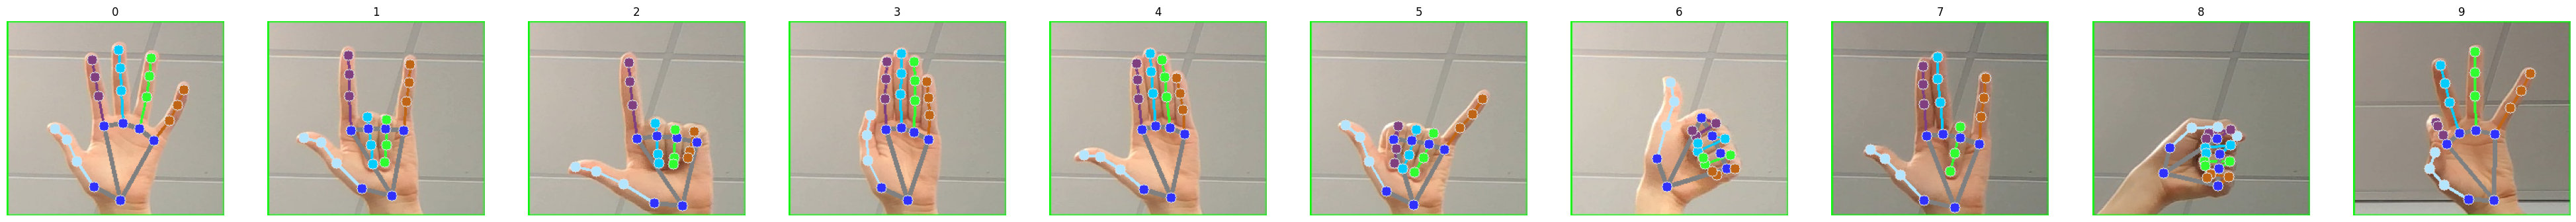

In [7]:
import os
import glob
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def get_one_image_from_each_folder(directory):
    images = []
    for root, dirs, files in os.walk(directory):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            image_files = glob.glob(folder_path + '/*.*')  
            if image_files:  
                images.append(image_files[0])  
    return images

def process_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    img_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

    return img_rgb

def plot_images(image_paths):
    num_images = len(image_paths)
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 5, 5))
    for i, image_path in enumerate(image_paths):
        img = process_image(image_path)
        axs[i].imshow(img)
        axs[i].set_title(os.path.basename(os.path.dirname(image_path)))
        axs[i].axis('off')
    plt.show()

if __name__ == "__main__":
    directory = './data'
    image_paths = get_one_image_from_each_folder(directory)
    plot_images(image_paths)


# Real Time Detection

In [17]:
import cv2
import mediapipe as mp
import numpy as np
from keras.models import load_model
import random

model = load_model('./cnn.h5')

cap = cv2.VideoCapture(0)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

labels_dict = {
    0: "Hello",
    1: "I Love You",
    2: "Yes",
    3: "Stop",
    4: "Calm",
    5: "Why",
    6: "Fine",
    7: "I Hate You",
    8: "Sorry",
    9: "Money"
}

words = list(labels_dict.values())

top, right, bottom, left = 10, 350, 225, 590

score = 0
currentWord = str(random.choice(words))

while True:
    data_aux = []
    x_ = []
    y_ = []

    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)  # Flip the frame horizontally

    H, W, _ = frame.shape

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Define the region of interest
    roi = frame_rgb[top:bottom, right:left]

    if roi.size > 0:
        # Process the ROI with MediaPipe
        results = hands.process(roi)

        
        try: #To prevent crashing when two hands enter the frame
            cv2.putText(frame, "Please Sign: "+currentWord, (10, H-30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) #Word user must sign
            cv2.putText(frame, "Score: "+str(score), (W-350, H-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2) #Score tracking how many correct words

        
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:

                    for i in range(21):
                        x = hand_landmarks.landmark[i].x
                        y = hand_landmarks.landmark[i].y
                        x_.append(x)
                        y_.append(y)

                    for i in range(21):
                        x = hand_landmarks.landmark[i].x
                        y = hand_landmarks.landmark[i].y
                        data_aux.append(x - min(x_))
                        data_aux.append(y - min(y_))

        

                    # Reshape the input data to the expected shape
                    input_data = np.array(data_aux).reshape(1, 6, 7, 1)

                    input_data = input_data / 255.0

                    prediction = model.predict(input_data)
                    predicted_character = np.argmax(prediction[0])
            
                    if predicted_character is not None:
                        cv2.putText(frame, f"Predicted Word: {labels_dict[predicted_character]}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
                        if labels_dict[predicted_character] == currentWord:
                            newWord = str(random.choice(words))
                            while newWord == currentWord:
                                newWord = str(random.choice(words))
                            currentWord = newWord
                            score += 1
        except:
            cv2.putText(frame, "TWO HANDS DETECTED!", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)


    # Draw the ROI rectangle on the frame
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)

    cv2.imshow('frame', frame)
    cv2.waitKey(1)

    keypress = cv2.waitKey(1) & 0xFF
    if keypress == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()



1/1 [==============================] - 0s 38ms/step
